In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sc.stop()

NameError: name 'sc' is not defined

In [ ]:
spark.stop()

In [3]:
from pyspark import SparkConf, SparkContext

config = SparkConf().setAppName("SQLAssignmentSession")
sc = SparkContext(conf=config)

24/09/24 07:10:20 WARN Utils: Your hostname, aurora resolves to a loopback address: 127.0.1.1; using 192.168.29.188 instead (on interface wlan0)
24/09/24 07:10:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/24 07:10:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/24 07:10:23 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SQLAssignmentSession').getOrCreate()

In [5]:
spark

24/09/24 07:10:34 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [6]:
churn_df = spark.read.csv('file:///home/cy34/Downloads/Telco_Customer_Churn.csv', 
                            header=True,
                            inferSchema=True)

In [ ]:
churn_df.printSchema

In [ ]:
from pyspark.sql.functions import col, sum

null_counts = churn_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in churn_df.columns])
null_counts.collect()

In [9]:
churn_df.createOrReplaceTempView('churn_data')

In [ ]:
spark.sql("""
SELECT count(*) as rows
FROM churn_data
""").show()

spark.sql(f"""
 SHOW COLUMNS IN churn_data
""").show()

#### a) Analyze how customer retention varies based on how long the customer has stayed with the company (tenure).

In [15]:
churn_rate_df = spark.sql("""
SELECT 
    tenure,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) AS churn_rate
FROM churn_data
GROUP BY tenure
ORDER BY tenure
""")

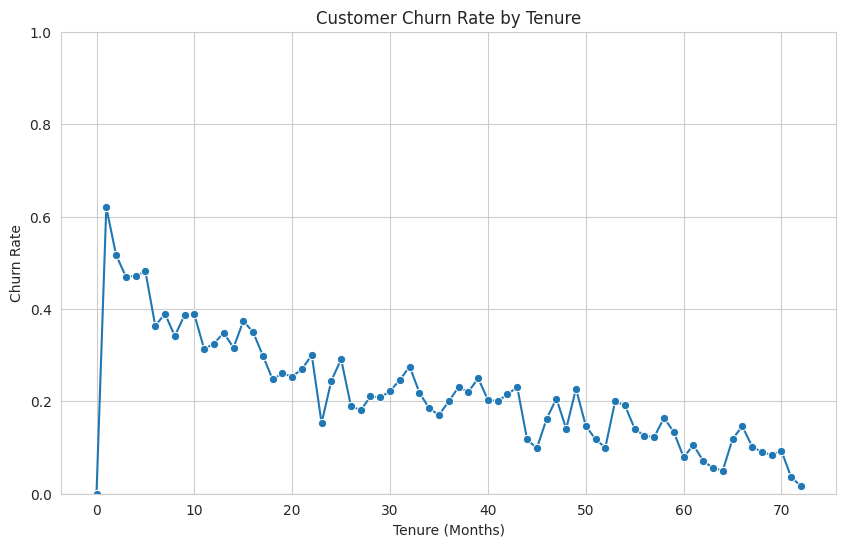

In [16]:
churn_rate_pd = churn_rate_df.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(x='tenure', y='churn_rate', data=churn_rate_pd, marker='o')

plt.title('Customer Churn Rate by Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)  

plt.show()

**Insights**
- We can see that the churn rate is quite high(0.8) during the initial 0-5 months, which indicates most of the users may stop the service shortly after signing up
- But after the first months, there is a sharp decline the churn rate, around the 10 month the decline stabilices, indicating long term users.

#### b) Investigate the churn rate of customers who subscribe to streaming services like StreamingTV and StreamingMovies.

In [17]:

churn_streaming_df = spark.sql("""
SELECT 
    CASE 
        WHEN StreamingTV = 'Yes' AND StreamingMovies = 'Yes' THEN 'Both StreamingTV and StreamingMovies'
        WHEN StreamingTV = 'Yes' THEN 'Only StreamingTV'
        WHEN StreamingMovies = 'Yes' THEN 'Only StreamingMovies'
        ELSE 'No Streaming Services'
    END AS streaming_service_group,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) AS churn_rate
FROM churn_data
WHERE InternetService != 'No'
GROUP BY streaming_service_group
ORDER BY streaming_service_group
""")

churn_streaming_df.show()


+-----------------------+---------------+-----------------+-------------------+
|streaming_service_group|total_customers|churned_customers|         churn_rate|
+-----------------------+---------------+-----------------+-------------------+
|   Both StreamingTV ...|           1940|              571| 0.2943298969072165|
|   No Streaming Serv...|           2018|              695|  0.344400396432111|
|   Only StreamingMovies|            792|              247|0.31186868686868685|
|       Only StreamingTV|            767|              243|0.31681877444589307|
+-----------------------+---------------+-----------------+-------------------+



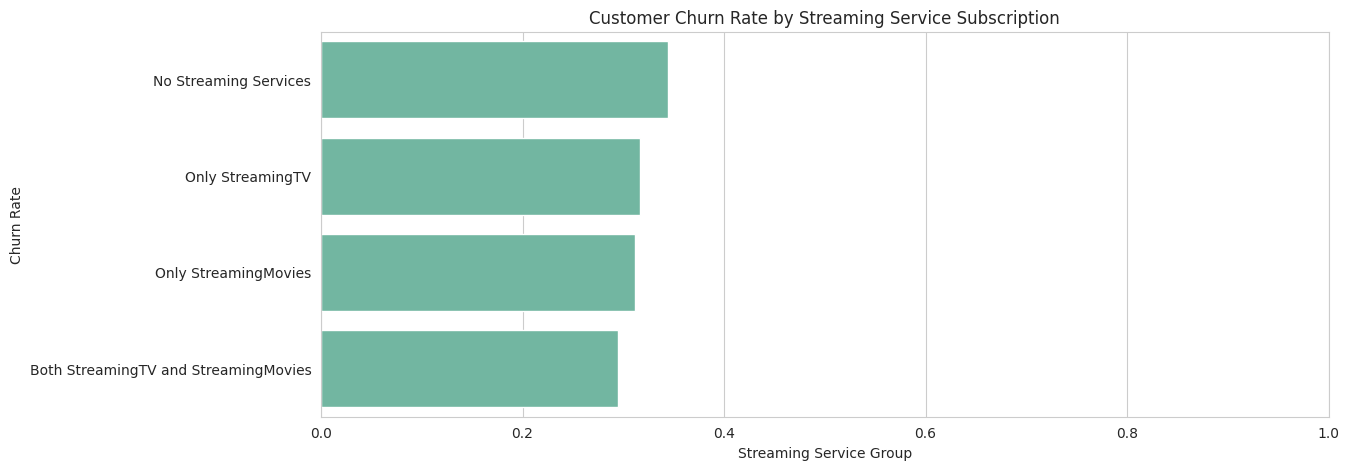

In [18]:

churn_streaming_pd = churn_streaming_df.toPandas()
churn_streaming_pd = churn_streaming_pd.sort_values(by='churn_rate', ascending=False)


sns.set_palette("Set2")  

plt.figure(figsize=(13, 5))
sns.barplot(y='streaming_service_group', x='churn_rate', data=churn_streaming_pd)

plt.title('Customer Churn Rate by Streaming Service Subscription')
plt.xlabel('Streaming Service Group')
plt.ylabel('Churn Rate')
plt.xlim(0, 1)  

plt.show()

**Insights**
- churn rate is higher in customers of streaming movies

#### c) Write Spark SQL to group customers by their tenure (e.g., 0-12 months, 13-24 months, etc.) and analyze churn rates in these tenure groups.

In [19]:

churn_tenure_df = spark.sql("""
SELECT 
    CASE 
        WHEN tenure <= 12 THEN '0-12 Months'
        WHEN tenure > 12 AND tenure <= 24 THEN '13-24 Months'
        WHEN tenure > 24 AND tenure <= 36 THEN '25-36 Months'
        WHEN tenure > 36 AND tenure <= 48 THEN '37-48 Months'
        ELSE '49+ Months'
    END AS tenure_group,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) AS churn_rate
FROM churn_data
GROUP BY tenure_group
ORDER BY tenure_group
""")

churn_tenure_df.show()


+------------+---------------+-----------------+-------------------+
|tenure_group|total_customers|churned_customers|         churn_rate|
+------------+---------------+-----------------+-------------------+
| 0-12 Months|           2186|             1037|0.47438243366880145|
|13-24 Months|           1024|              294|        0.287109375|
|25-36 Months|            832|              180|0.21634615384615385|
|37-48 Months|            762|              145|0.19028871391076116|
|  49+ Months|           2239|              213|0.09513175524787852|
+------------+---------------+-----------------+-------------------+



/tmp/ipykernel_41230/1538871625.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tenure_group', y='churn_rate', data=churn_tenure_pd, palette="Set2")


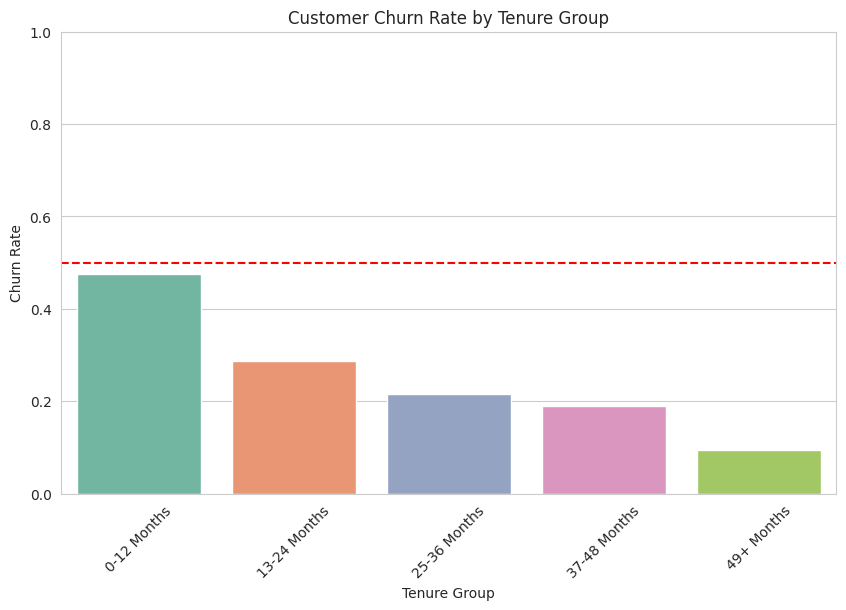

In [20]:

churn_tenure_pd = churn_tenure_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='tenure_group', y='churn_rate', data=churn_tenure_pd, palette="Set2")

plt.title('Customer Churn Rate by Tenure Group')
plt.xlabel('Tenure Group')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)  
plt.axhline(y=0.5, color='r', linestyle='--')  
plt.xticks(rotation=45)

plt.show()


#### d) Analyze the impact of contract types and payment methods on churn rates.

In [21]:

contract_payment_churn_df = spark.sql(
"""
SELECT 
    Contract,
    PaymentMethod,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) AS churn_rate
FROM churn_data
GROUP BY Contract, PaymentMethod
ORDER BY Contract, PaymentMethod
""")

contract_payment_churn_df.show()


+--------------+--------------------+---------------+-----------------+--------------------+
|      Contract|       PaymentMethod|total_customers|churned_customers|          churn_rate|
+--------------+--------------------+---------------+-----------------+--------------------+
|Month-to-month|Bank transfer (au...|            589|              201| 0.34125636672325976|
|Month-to-month|Credit card (auto...|            543|              178|  0.3278084714548803|
|Month-to-month|    Electronic check|           1850|              994|  0.5372972972972972|
|Month-to-month|        Mailed check|            893|              282|  0.3157894736842105|
|      One year|Bank transfer (au...|            391|               38| 0.09718670076726342|
|      One year|Credit card (auto...|            398|               41| 0.10301507537688442|
|      One year|    Electronic check|            347|               64|  0.1844380403458213|
|      One year|        Mailed check|            337|               23

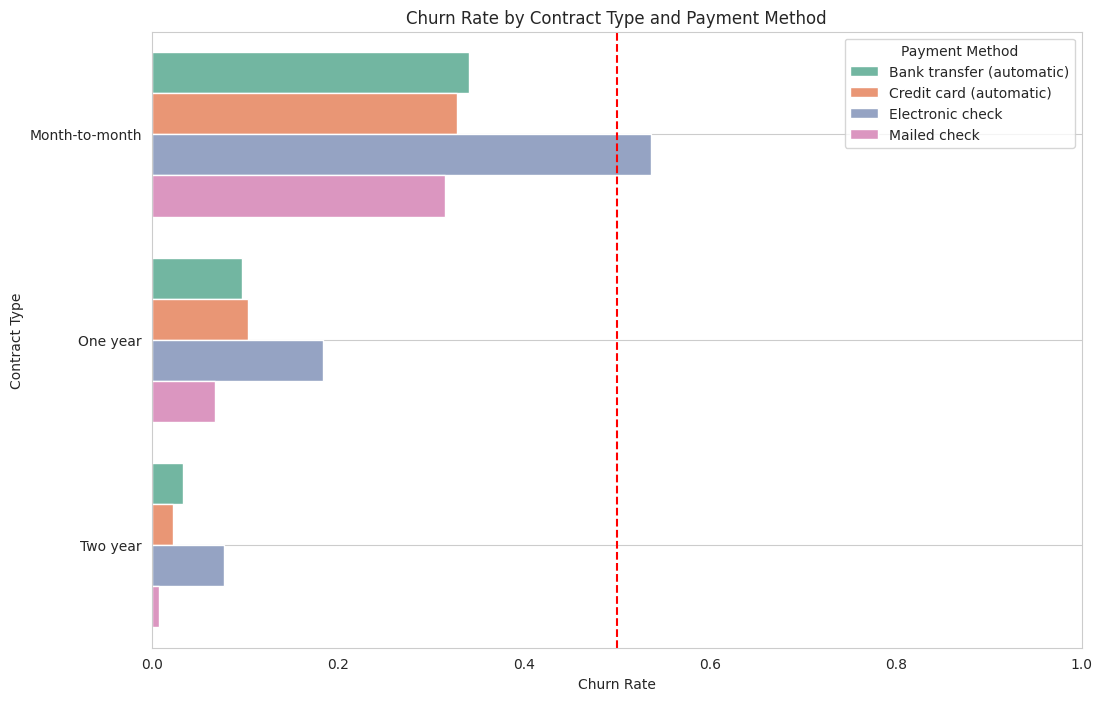

In [22]:
contract_payment_churn_pd = contract_payment_churn_df.toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x='churn_rate', y='Contract', hue='PaymentMethod', data=contract_payment_churn_pd, palette='Set2')

plt.title('Churn Rate by Contract Type and Payment Method')
plt.xlabel('Churn Rate')
plt.ylabel('Contract Type')
plt.xlim(0, 1) 

plt.axvline(x=0.5, color='r', linestyle='--') 
plt.legend(title='Payment Method')
plt.grid()
plt.show()


#### e) Explore the distribution of monthly charges for customers based on their type of internet service.

In [23]:
monthly_charges_internet_df = spark.sql(
"""
SELECT 
    InternetService,
    MonthlyCharges
FROM 
    churn_data
""")

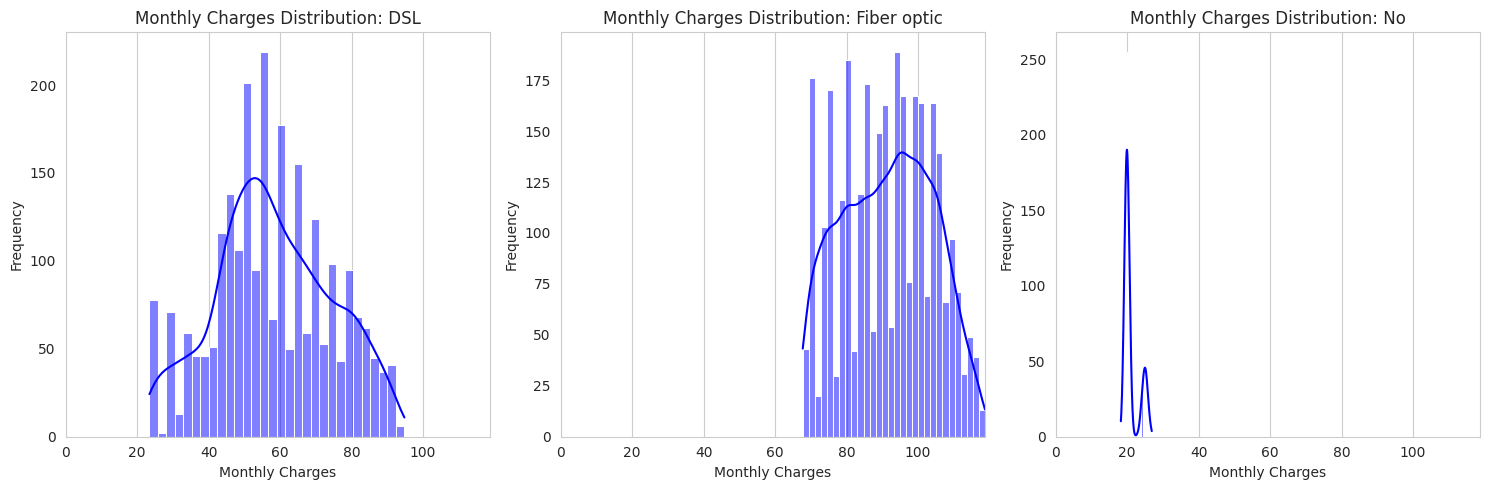

In [24]:

monthly_charges_internet_pd = monthly_charges_internet_df.toPandas()

plt.figure(figsize=(15, 5))

services = monthly_charges_internet_pd['InternetService'].unique()

for i, service in enumerate(services, 1):
    plt.subplot(1, 3, i) 
    sns.histplot(monthly_charges_internet_pd[monthly_charges_internet_pd['InternetService'] == service],
                 x='MonthlyCharges', bins=30, kde=True, color='blue')
    plt.title(f'Monthly Charges Distribution: {service}')
    plt.xlabel('Monthly Charges')
    plt.ylabel('Frequency')
    plt.xlim(0, monthly_charges_internet_pd['MonthlyCharges'].max())  # Limit x-axis to max monthly charges
    plt.grid(axis='y')

plt.tight_layout() 
plt.show()


#### f) Identify the top 10 customers who have contributed the most revenue to the company, based on total charges.

In [25]:
top_customers_df = spark.sql(
"""
SELECT 
    customerID, 
    TotalCharges 
FROM 
    churn_data 
ORDER BY 
    TotalCharges DESC 
LIMIT 10
""")

top_customers_df.show()


+----------+------------+
|customerID|TotalCharges|
+----------+------------+
|9093-FPDLG|       999.9|
|4536-PLEQY|       999.8|
|5899-MQZZL|      999.45|
|6051-PTVNS|       998.1|
|8249-THVEC|      997.75|
|6328-ZPBGN|      997.65|
|7297-DVYGA|      996.95|
|6243-OZGFH|      996.85|
|0484-JPBRU|      996.45|
|2971-SGAFL|      995.35|
+----------+------------+



#### g) Calculate the churn rate segmented by gender and whether the customer is a senior citizen.

In [26]:
churn_rate_gender_senior_df = spark.sql(
"""
SELECT 
    gender,
    SeniorCitizen,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) AS churn_rate
FROM 
    churn_data
GROUP BY 
    gender, SeniorCitizen
ORDER BY 
    gender, SeniorCitizen
""")

churn_rate_gender_senior_df.show()


+------+-------------+---------------+-----------------+-------------------+
|gender|SeniorCitizen|total_customers|churned_customers|         churn_rate|
+------+-------------+---------------+-----------------+-------------------+
|Female|            0|           2920|              699|0.23938356164383562|
|Female|            1|            568|              240| 0.4225352112676056|
|  Male|            0|           2981|              694|0.23280778262328078|
|  Male|            1|            574|              236|0.41114982578397213|
+------+-------------+---------------+-----------------+-------------------+



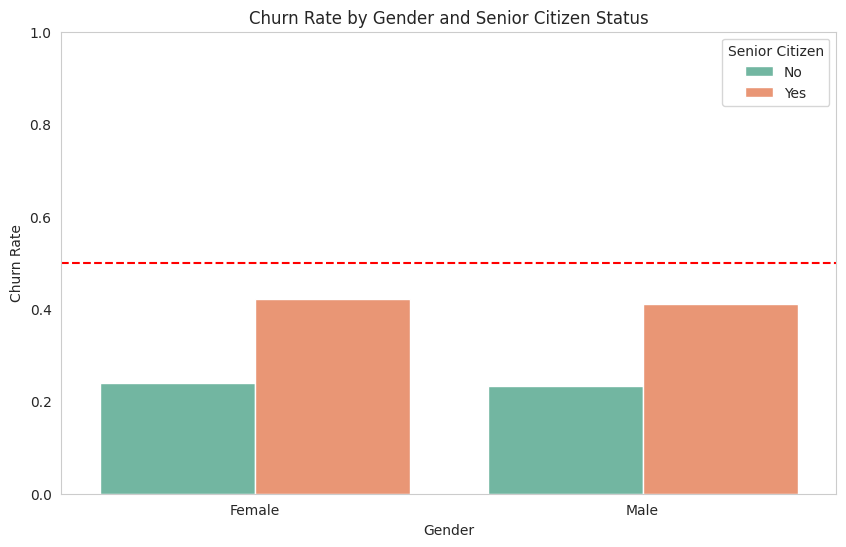

In [27]:
churn_rate_gender_senior_pd = churn_rate_gender_senior_df.toPandas()

churn_rate_gender_senior_pd['SeniorCitizen'] = churn_rate_gender_senior_pd['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

plt.figure(figsize=(10, 6))

sns.barplot(x='gender', y='churn_rate', hue='SeniorCitizen', data=churn_rate_gender_senior_pd, palette='Set2')

plt.title('Churn Rate by Gender and Senior Citizen Status')
plt.xlabel('Gender')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)  
plt.axhline(y=0.5, color='r', linestyle='--') 
plt.legend(title='Senior Citizen')
plt.grid(axis='y')

plt.show()

#### h) Write query to calculate Correlation between dependents and churn. Explore whether having dependents affects customer churn rates.

In [28]:
correlation_result = spark.sql(
"""
SELECT 
    CORR(DependentsNum, ChurnNum) AS correlation
FROM (
    SELECT 
        CAST(CASE WHEN Dependents = 'Yes' THEN 1 ELSE 0 END AS INT) AS DependentsNum,
        CAST(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END AS INT) AS ChurnNum
    FROM 
        churn_data
) AS correlation_data
""")

correlation_result.show()


+--------------------+
|         correlation|
+--------------------+
|-0.16422140157972537|
+--------------------+



/tmp/ipykernel_41230/3712182053.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dependents', y='churn_rate', data=dependents_churn_rate_pd, palette='Set2')


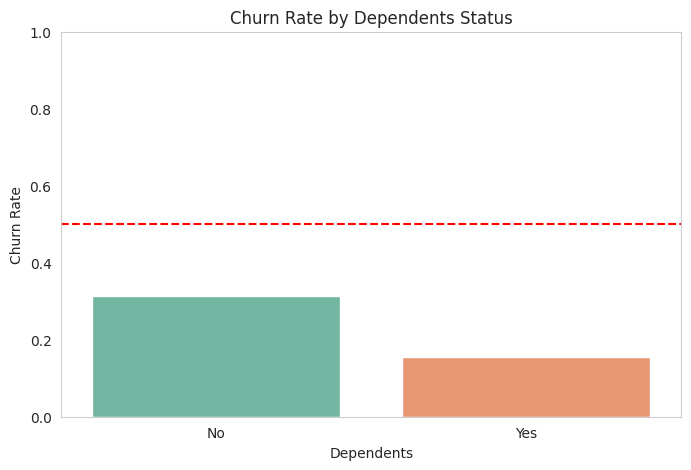

In [29]:
dependents_churn_rate_df = spark.sql(
"""
SELECT 
    Dependents,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) AS churn_rate
FROM 
    churn_data
GROUP BY 
    Dependents
""")



dependents_churn_rate_pd = dependents_churn_rate_df.toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(x='Dependents', y='churn_rate', data=dependents_churn_rate_pd, palette='Set2')

plt.title('Churn Rate by Dependents Status')
plt.xlabel('Dependents')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)
plt.axhline(y=0.5, color='r', linestyle='--')  # Optional: add a line at 0.5 for reference
plt.grid(axis='y')

plt.show()


#### i) Predict potential churn rates by analyzing the relationship between monthly charges, contract types, and the churn rate.

In [30]:
churn_rate_monthly_contract_df = spark.sql(
"""
SELECT 
    Contract,
    CASE 
        WHEN MonthlyCharges < 30 THEN '<30'
        WHEN MonthlyCharges BETWEEN 30 AND 60 THEN '30-60'
        WHEN MonthlyCharges > 60 THEN '>60'
    END AS MonthlyChargeRange,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) AS churn_rate
FROM 
    churn_data
GROUP BY 
    Contract, MonthlyChargeRange
ORDER BY 
    Contract, MonthlyChargeRange
""")

churn_rate_monthly_contract_df.show()


+--------------+------------------+---------------+-----------------+--------------------+
|      Contract|MonthlyChargeRange|total_customers|churned_customers|          churn_rate|
+--------------+------------------+---------------+-----------------+--------------------+
|Month-to-month|             30-60|            851|              304|  0.3572267920094007|
|Month-to-month|               <30|            642|              147| 0.22897196261682243|
|Month-to-month|               >60|           2382|             1204|  0.5054575986565911|
|      One year|             30-60|            251|               19| 0.07569721115537849|
|      One year|               <30|            372|               10|0.026881720430107527|
|      One year|               >60|            850|              137| 0.16117647058823528|
|      Two year|             30-60|            163|                5| 0.03067484662576687|
|      Two year|               <30|            639|                5| 0.00782472613458529|

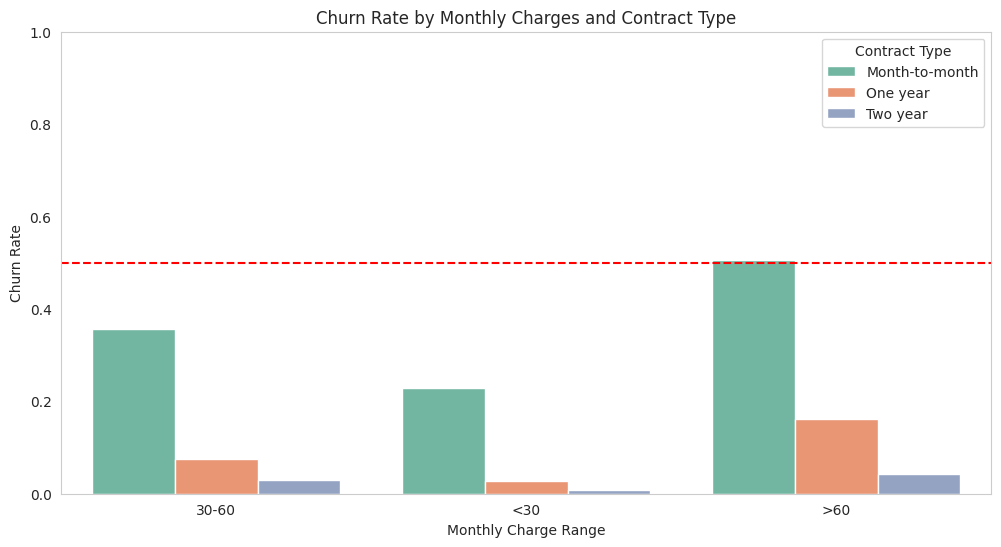

In [31]:
churn_rate_monthly_contract_pd = churn_rate_monthly_contract_df.toPandas()

plt.figure(figsize=(12, 6))

sns.barplot(x='MonthlyChargeRange', y='churn_rate', hue='Contract', data=churn_rate_monthly_contract_pd, palette='Set2')

plt.title('Churn Rate by Monthly Charges and Contract Type')
plt.xlabel('Monthly Charge Range')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.legend(title='Contract Type')
plt.grid(axis='y')

plt.show()

#### j) Determine the churn rate for customers who have multiple services (Phone, Internet, and Streaming), which can help understand whether bundling services leads to higher or lower churn. Calculate churn rate for customers with multiple services.

In [32]:
churn_rate_multiple_services_df = spark.sql(
"""
SELECT 
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) AS churn_rate
FROM 
    churn_data
WHERE 
    PhoneService = 'Yes' 
    AND InternetService != 'No' 
    AND (StreamingTV = 'Yes' OR StreamingMovies = 'Yes')
""")

churn_rate_multiple_services_df.show()


+---------------+-----------------+-------------------+
|total_customers|churned_customers|         churn_rate|
+---------------+-----------------+-------------------+
|           3116|              968|0.31065468549422337|
+---------------+-----------------+-------------------+



#### k) Churn Impact by device protection and online backup services. Write query to investigate whether having device protection or online backup services affects churn rates.

In [73]:
query = """
SELECT 
    CASE 
        WHEN DeviceProtection = 'Yes' AND OnlineBackup = 'Yes' THEN 'Both'
        WHEN DeviceProtection = 'Yes' AND OnlineBackup = 'No' THEN 'Only Device Protection'
        WHEN DeviceProtection = 'No' AND OnlineBackup = 'Yes' THEN 'Only Online Backup'
        ELSE 'Neither'
    END AS ServiceCombination,
    COUNT(*) AS TotalCustomers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS ChurnedCustomers,
    ROUND(SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS ChurnRate
FROM 
    churn_data
GROUP BY 
    CASE 
        WHEN DeviceProtection = 'Yes' AND OnlineBackup = 'Yes' THEN 'Both'
        WHEN DeviceProtection = 'Yes' AND OnlineBackup = 'No' THEN 'Only Device Protection'
        WHEN DeviceProtection = 'No' AND OnlineBackup = 'Yes' THEN 'Only Online Backup'
        ELSE 'Neither'
    END
ORDER BY 
    ChurnRate DESC
"""

result = spark.sql(query)

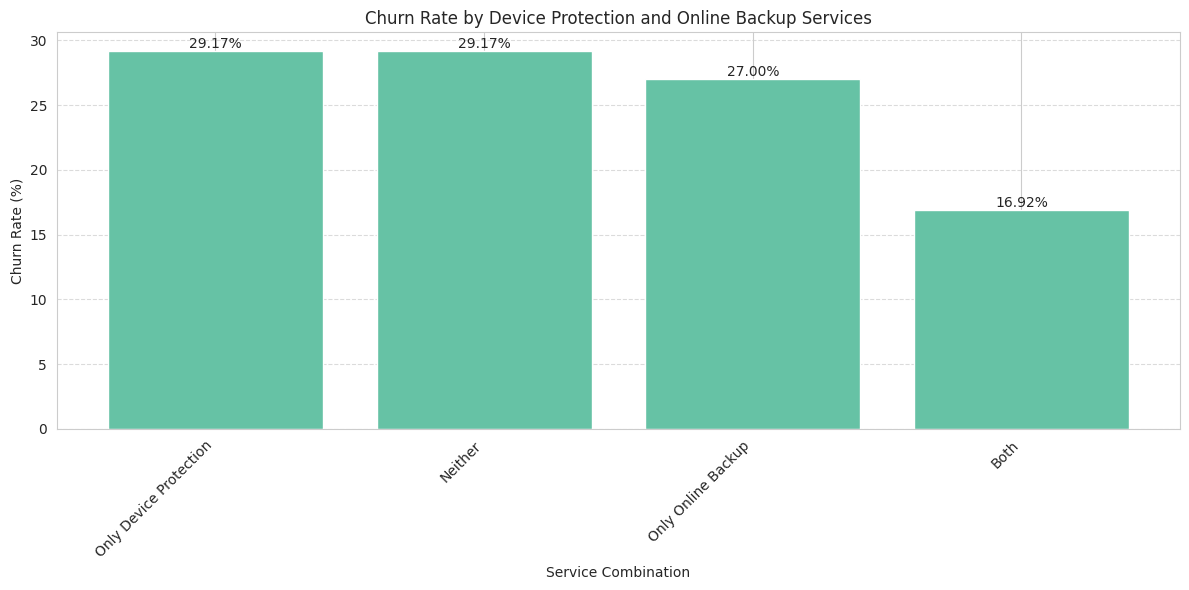

In [76]:
pandas_df = result.toPandas()

# Create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(pandas_df['ServiceCombination'], pandas_df['ChurnRate'])

# Customize the plot
plt.title('Churn Rate by Device Protection and Online Backup Services')
plt.xlabel('Service Combination')
plt.ylabel('Churn Rate (%)')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

#### l) Explore churn rates among customers who do not have phone service and investigate if it influences customer retention.

In [78]:
query = """
SELECT 
    PhoneService,
    InternetService,
    COUNT(*) AS TotalCustomers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS ChurnedCustomers,
    ROUND(SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS ChurnRate
FROM 
    churn_data
GROUP BY 
    PhoneService, InternetService
ORDER BY 
    PhoneService, InternetService
"""

result = spark.sql(query)

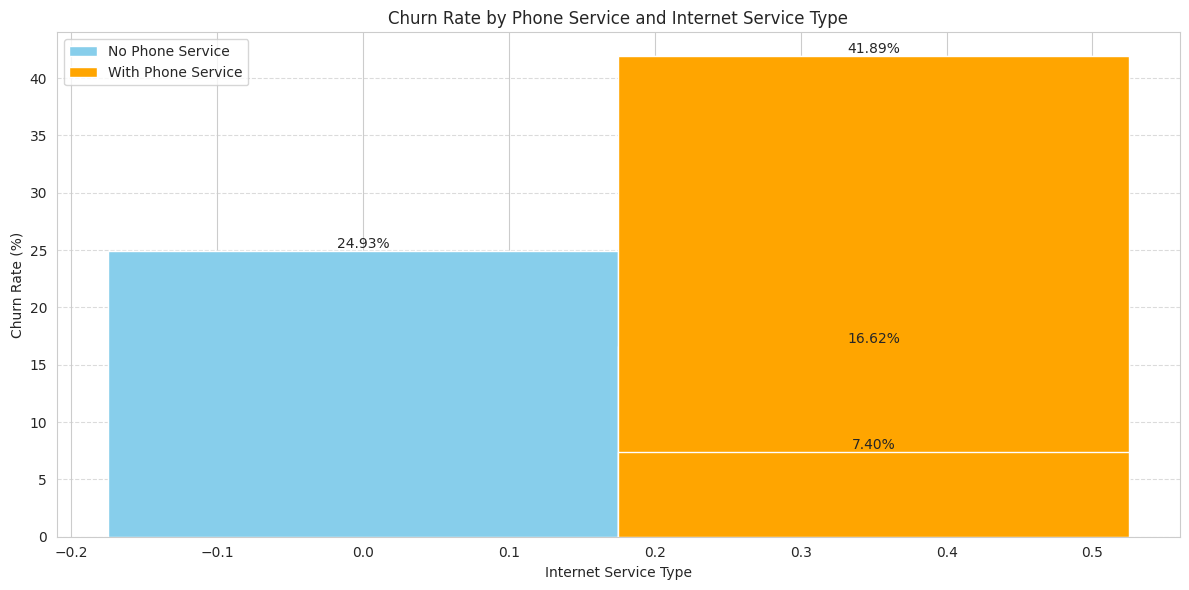

In [82]:
# Convert the result to a Pandas DataFrame for easier plotting
pandas_df = result.toPandas()

# Create a grouped bar plot
plt.figure(figsize=(12, 6))

no_phone = pandas_df[pandas_df['PhoneService'] == 'No']
with_phone = pandas_df[pandas_df['PhoneService'] == 'Yes']

bar_width = 0.35
r1 = range(len(no_phone))
r2 = [x + bar_width for x in r1]

plt.bar(r1, no_phone['ChurnRate'], color='skyblue', width=bar_width, label='No Phone Service')
plt.bar(r2, with_phone['ChurnRate'], color='orange', width=bar_width, label='With Phone Service')

plt.title('Churn Rate by Phone Service and Internet Service Type')
plt.xlabel('Internet Service Type')
plt.ylabel('Churn Rate (%)')

# Add value labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%',
                 ha='center', va='bottom')

add_labels(plt.bar(r1, no_phone['ChurnRate'], color='skyblue', width=bar_width))
add_labels(plt.bar(r2, with_phone['ChurnRate'], color='orange', width=bar_width))

# Add a legend
plt.legend()

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

#### m) Understand the relationship between payment methods and contract types on customer churn. This query will help you discover which combinations are most prone to churn.

In [37]:
churn_analysis_result = spark.sql("""
SELECT 
    PaymentMethod, 
    Contract, 
    COUNT(*) AS TotalCustomers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS ChurnedCustomers,
    (SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS ChurnRate
FROM 
    churn_data
GROUP BY 
    PaymentMethod, 
    Contract
ORDER BY 
    ChurnRate DESC
""")

churn_analysis_result.show()

+--------------------+--------------+--------------+----------------+------------------+
|       PaymentMethod|      Contract|TotalCustomers|ChurnedCustomers|         ChurnRate|
+--------------------+--------------+--------------+----------------+------------------+
|    Electronic check|Month-to-month|          1850|             994|53.729729729729726|
|Bank transfer (au...|Month-to-month|           589|             201|34.125636672325975|
|Credit card (auto...|Month-to-month|           543|             178| 32.78084714548803|
|        Mailed check|Month-to-month|           893|             282| 31.57894736842105|
|    Electronic check|      One year|           347|              64|18.443804034582133|
|Credit card (auto...|      One year|           398|              41|10.301507537688442|
|Bank transfer (au...|      One year|           391|              38| 9.718670076726342|
|    Electronic check|      Two year|           168|              13| 7.738095238095238|
|        Mailed check

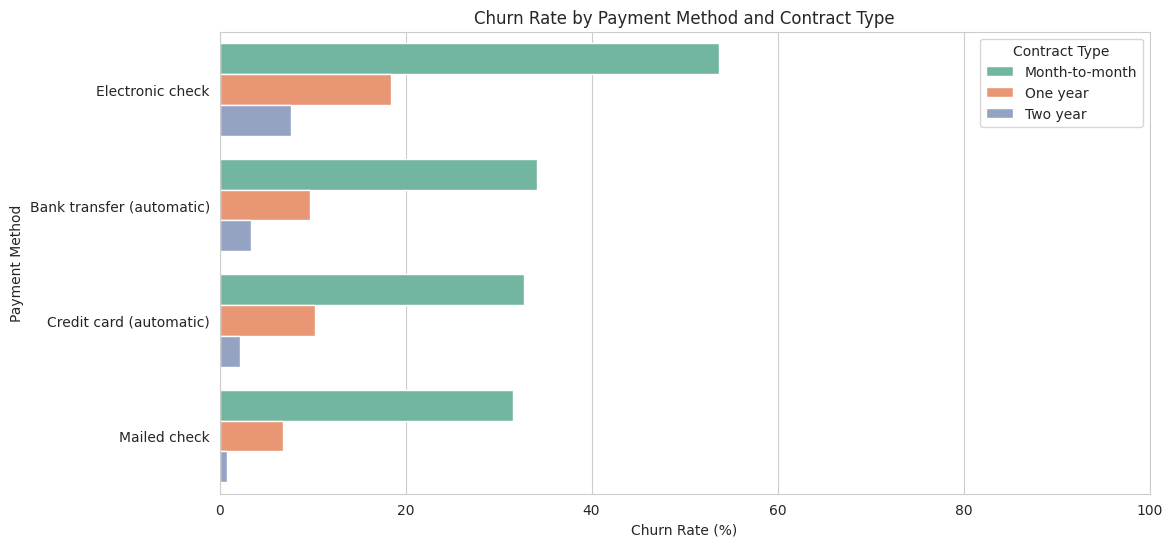

In [38]:
churn_analysis_df = churn_analysis_result.toPandas()

plt.figure(figsize=(12, 6))

sns.barplot(data=churn_analysis_df, x='ChurnRate', y='PaymentMethod', hue='Contract')

plt.title('Churn Rate by Payment Method and Contract Type')
plt.xlabel('Churn Rate (%)')
plt.ylabel('Payment Method')
plt.legend(title='Contract Type')
plt.xlim(0, 100)  

plt.show()

#### n) Analyze how customer churn is affected by senior citizen status and whether the customer has dependents.

In [63]:
churn_analysis_query = spark.sql("""
    SELECT 
        CASE 
            WHEN SeniorCitizen = 1 THEN 'Senior'
            ELSE 'Non-Senior'
        END as senior_status,
        Dependents,
        COUNT(*) as total_customers,
        SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) as churn_rate
    FROM churn_data
    GROUP BY 
        CASE 
            WHEN SeniorCitizen = 1 THEN 'Senior'
            ELSE 'Non-Senior'
        END,
        Dependents
""")

churn_analysis_query.show()

+-------------+----------+---------------+-------------------+
|senior_status|Dependents|total_customers|         churn_rate|
+-------------+----------+---------------+-------------------+
|       Senior|       Yes|             91|0.24175824175824176|
|   Non-Senior|       Yes|           2019| 0.1505695889053987|
|   Non-Senior|        No|           3882|0.28052550231839257|
|       Senior|        No|           1051| 0.4319695528068506|
+-------------+----------+---------------+-------------------+



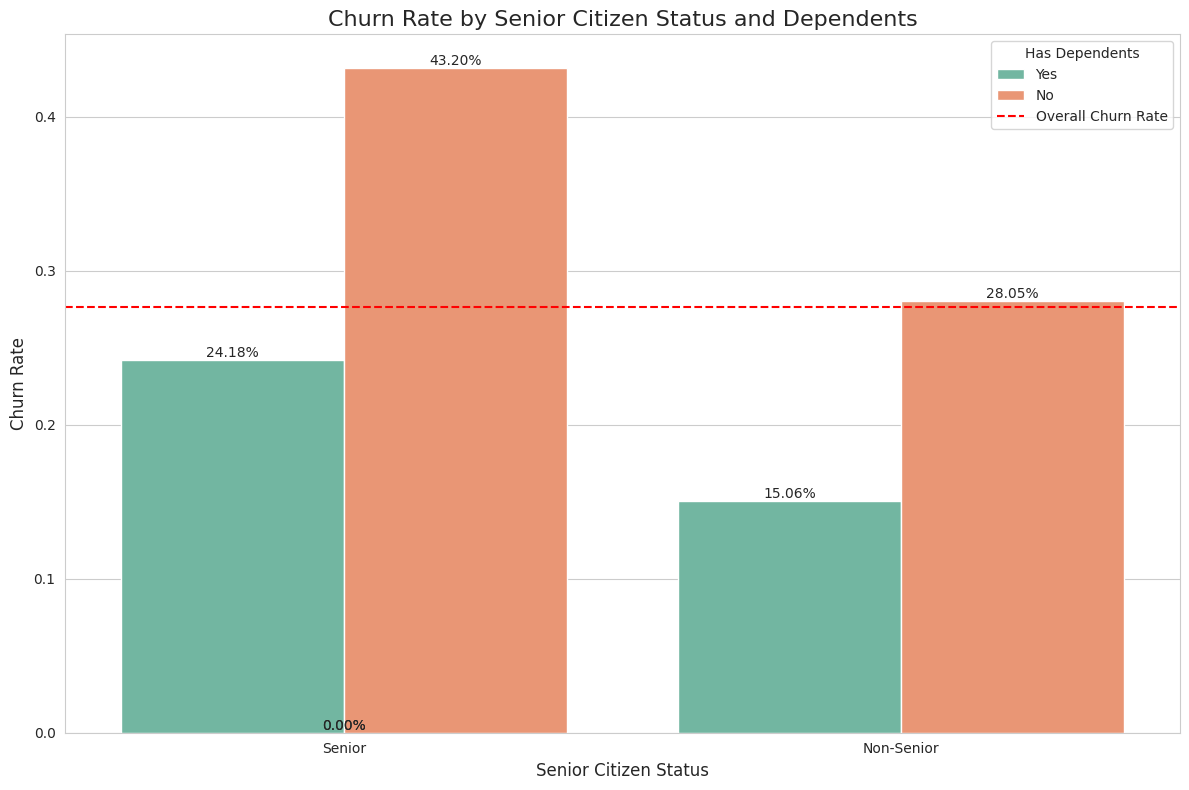

In [66]:
churn_df = churn_analysis_query.toPandas()

# Calculate overall churn rate for reference
overall_churn_rate = churn_df['churn_rate'].mean()

# Create the visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='senior_status', y='churn_rate', hue='Dependents', data=churn_df)

# Customize the plot
plt.title("Churn Rate by Senior Citizen Status and Dependents", fontsize=16)
plt.xlabel("Senior Citizen Status", fontsize=12)
plt.ylabel("Churn Rate", fontsize=12)
plt.axhline(y=overall_churn_rate, color='r', linestyle='--', label='Overall Churn Rate')

# Add value labels on the bars
for i, bar in enumerate(plt.gca().patches):
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height(), 
             f'{bar.get_height():.2%}', 
             ha='center', va='bottom')

# # Add total customers as text
# for i, row in churn_df.iterrows():
#     plt.text(i % 2, row['churn_rate'], 
#              f"n={row['total_customers']}", 
#              ha='center', va='bottom', 
#              color='black', fontweight='bold')

plt.legend(title="Has Dependents")
plt.tight_layout()
plt.show()


#### o) Explore whether subscribing to streaming services like Streaming TV and Streaming Movies influences the churn rate.

In [69]:
streaming_churn_query = spark.sql("""
    SELECT 
        CASE 
            WHEN StreamingTV = 'Yes' AND StreamingMovies = 'Yes' THEN 'Both'
            WHEN StreamingTV = 'Yes' AND StreamingMovies = 'No' THEN 'TV Only'
            WHEN StreamingTV = 'No' AND StreamingMovies = 'Yes' THEN 'Movies Only'
            WHEN StreamingTV = 'No' AND StreamingMovies = 'No' THEN 'Neither'
            ELSE 'Unknown'
        END as streaming_status,
        COUNT(*) as total_customers,
        SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) as churned_customers,
        SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) as churn_rate
    FROM churn_data
    GROUP BY 
        CASE 
            WHEN StreamingTV = 'Yes' AND StreamingMovies = 'Yes' THEN 'Both'
            WHEN StreamingTV = 'Yes' AND StreamingMovies = 'No' THEN 'TV Only'
            WHEN StreamingTV = 'No' AND StreamingMovies = 'Yes' THEN 'Movies Only'
            WHEN StreamingTV = 'No' AND StreamingMovies = 'No' THEN 'Neither'
            ELSE 'Unknown'
        END
    ORDER BY streaming_status
""")

streaming_churn_query.show()

+----------------+---------------+-----------------+-------------------+
|streaming_status|total_customers|churned_customers|         churn_rate|
+----------------+---------------+-----------------+-------------------+
|            Both|           1940|              571| 0.2943298969072165|
|     Movies Only|            792|              247|0.31186868686868685|
|         Neither|           2018|              695|  0.344400396432111|
|         TV Only|            767|              243|0.31681877444589307|
|         Unknown|           1526|              113|0.07404980340760157|
+----------------+---------------+-----------------+-------------------+



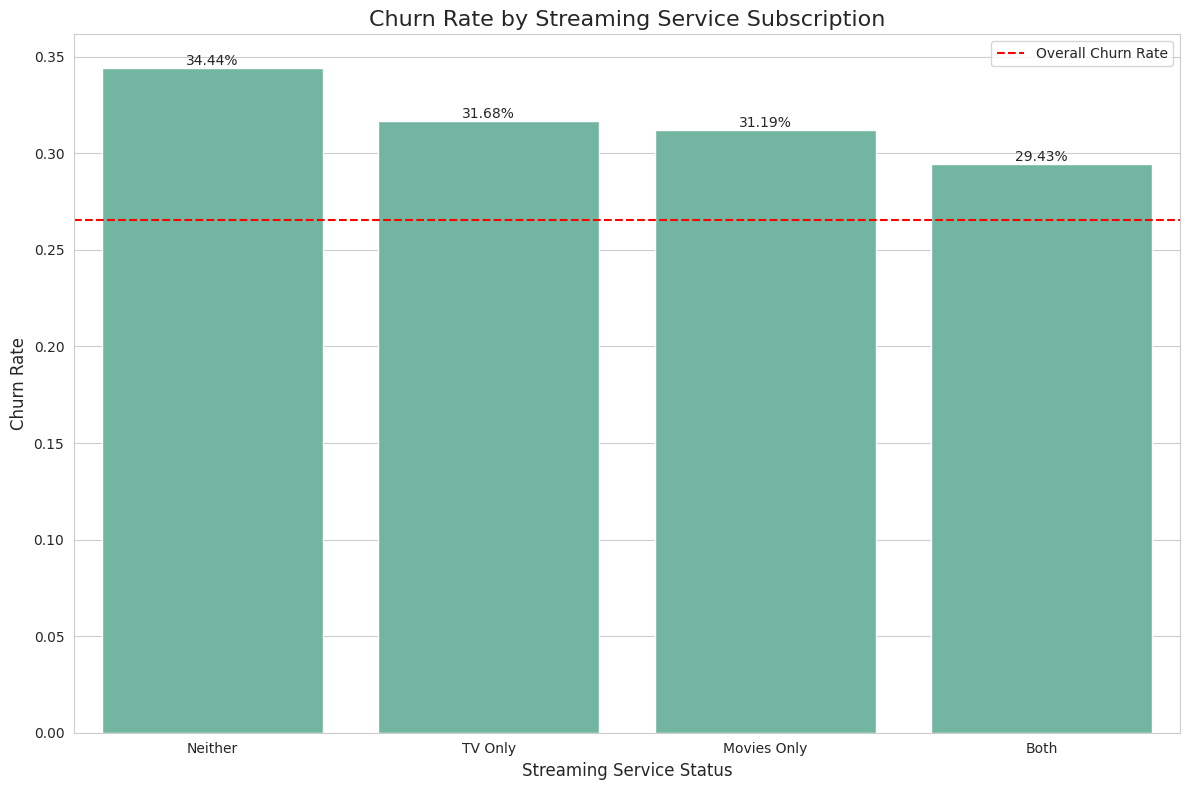

In [71]:
churn_df = streaming_churn_query.toPandas()

# Calculate overall churn rate for reference
overall_churn_rate = churn_df['churned_customers'].sum() / churn_df['total_customers'].sum()

# Create the visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='streaming_status', y='churn_rate', data=churn_df, 
            order=['Neither', 'TV Only', 'Movies Only', 'Both'])

# Customize the plot
plt.title("Churn Rate by Streaming Service Subscription", fontsize=16)
plt.xlabel("Streaming Service Status", fontsize=12)
plt.ylabel("Churn Rate", fontsize=12)
plt.axhline(y=overall_churn_rate, color='r', linestyle='--', label='Overall Churn Rate')

# Add value labels on the bars
for i, bar in enumerate(plt.gca().patches):
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height(), 
             f'{bar.get_height():.2%}', 
             ha='center', va='bottom')


plt.legend()
plt.tight_layout()
plt.show()


In [60]:

# 2. Churn rate for customers with streaming services
streaming_churn_query = spark.sql("""
    SELECT 
        CASE 
            WHEN StreamingTV = 'Yes' AND StreamingMovies = 'Yes' THEN 'Both'
            WHEN StreamingTV = 'Yes' AND StreamingMovies = 'No' THEN 'TV Only'
            WHEN StreamingTV = 'No' AND StreamingMovies = 'Yes' THEN 'Movies Only'
            ELSE 'Neither'
        END as streaming_status,
        COUNT(*) as total_customers,
        SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) as churned_customers,
        SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) as churn_rate
    FROM churn_data
    GROUP BY 
        CASE 
            WHEN StreamingTV = 'Yes' AND StreamingMovies = 'Yes' THEN 'Both'
            WHEN StreamingTV = 'Yes' AND StreamingMovies = 'No' THEN 'TV Only'
            WHEN StreamingTV = 'No' AND StreamingMovies = 'Yes' THEN 'Movies Only'
            ELSE 'Neither'
        END
    ORDER BY streaming_status
""")

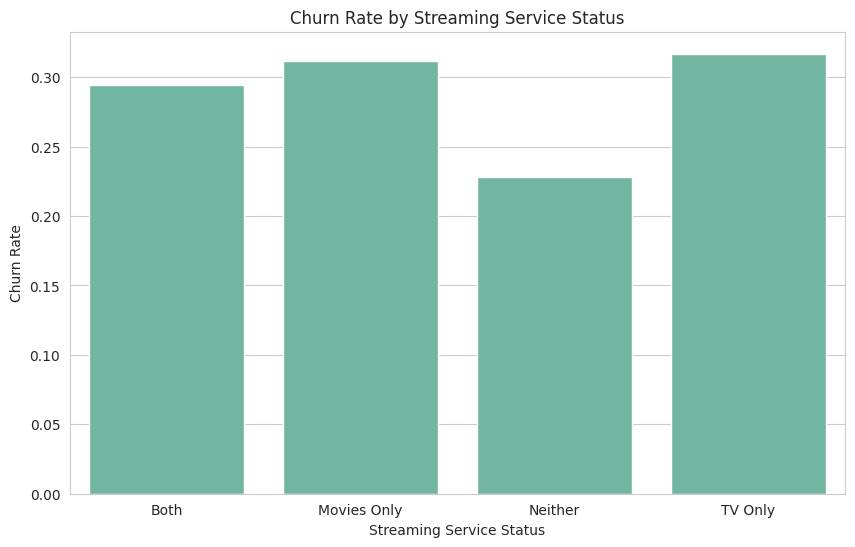

In [61]:
overall_churn_df = overall_churn_query.toPandas()
streaming_churn_df = streaming_churn_query.toPandas()
contract_streaming_churn_df = contract_streaming_churn_query.toPandas()

sns.set_style("whitegrid")


plt.figure(figsize=(10, 6))
sns.barplot(x='streaming_status', y='churn_rate', data=streaming_churn_df)
plt.title("Churn Rate by Streaming Service Status")
plt.xlabel("Streaming Service Status")
plt.ylabel("Churn Rate")
plt.show()



#### p) Understand how tenure and MonthlyCharges differ between churned and non-churned customers. This can provide insights into the behavior of long-term customers.

In [43]:
tenure_charges_result = spark.sql("""
SELECT 
    Churn, 
    AVG(tenure) AS AverageTenure,
    AVG(MonthlyCharges) AS AverageMonthlyCharges,
    COUNT(*) AS TotalCustomers
FROM 
    churn_data
GROUP BY 
    Churn
ORDER BY 
    Churn DESC
""")


tenure_charges_result.show()

+-----+------------------+---------------------+--------------+
|Churn|     AverageTenure|AverageMonthlyCharges|TotalCustomers|
+-----+------------------+---------------------+--------------+
|  Yes|17.979133226324237|     74.4413322632423|          1869|
|   No| 37.56996521066873|     61.2651236953999|          5174|
+-----+------------------+---------------------+--------------+



/tmp/ipykernel_41230/228612717.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tenure_charges_df, x='Churn', y='AverageTenure', ax=axes[0], palette='viridis')
/tmp/ipykernel_41230/228612717.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tenure_charges_df, x='Churn', y='AverageMonthlyCharges', ax=axes[1], palette='viridis')


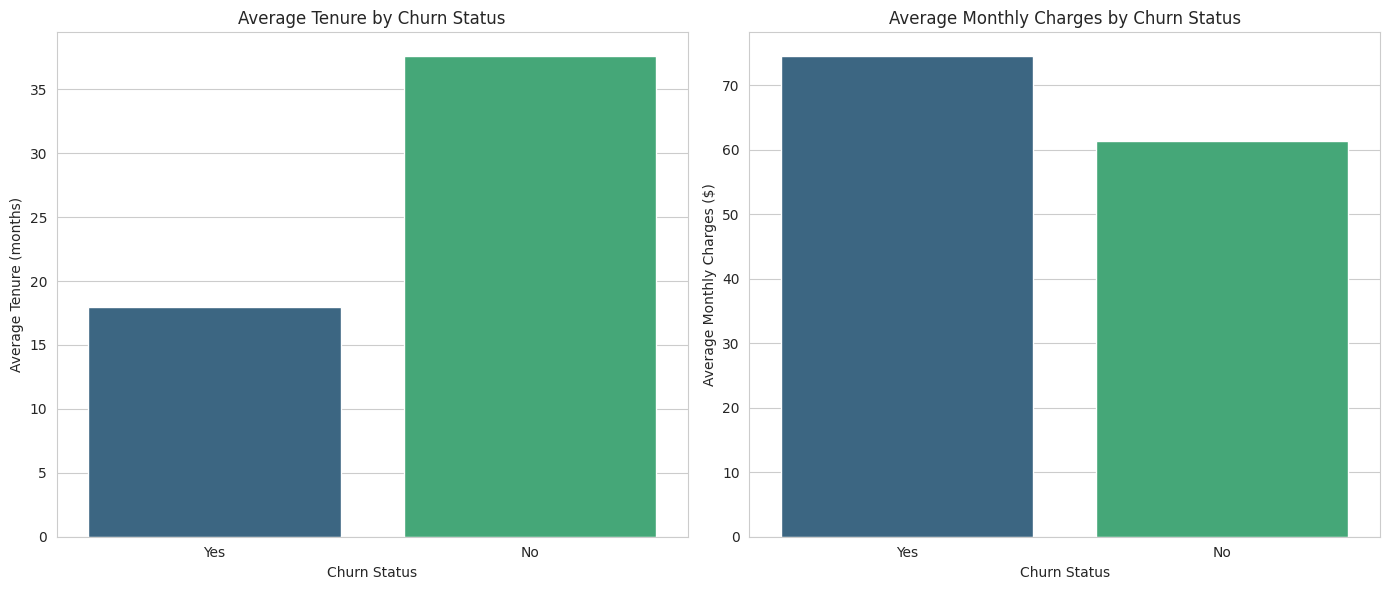

In [44]:
tenure_charges_df = tenure_charges_result.toPandas()

# Set up the figure for the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Average Tenure
sns.barplot(data=tenure_charges_df, x='Churn', y='AverageTenure', ax=axes[0], palette='viridis')
axes[0].set_title('Average Tenure by Churn Status')
axes[0].set_xlabel('Churn Status')
axes[0].set_ylabel('Average Tenure (months)')

# Plot for Average Monthly Charges
sns.barplot(data=tenure_charges_df, x='Churn', y='AverageMonthlyCharges', ax=axes[1], palette='viridis')
axes[1].set_title('Average Monthly Charges by Churn Status')
axes[1].set_xlabel('Churn Status')
axes[1].set_ylabel('Average Monthly Charges ($)')

# Show the plots
plt.tight_layout()
plt.show()


#### q) Compare monthly charges and churn rates between newer customers and long-time customers.

In [45]:
churn_tenure_comparison_result = spark.sql("""
SELECT 
    CASE 
        WHEN tenure < 12 THEN 'Newer Customers' 
        ELSE 'Long-Time Customers' 
    END AS CustomerType,
    COUNT(*) AS TotalCustomers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS ChurnedCustomers,
    AVG(MonthlyCharges) AS AverageMonthlyCharges,
    (SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS ChurnRate
FROM 
    churn_data
GROUP BY 
    CustomerType
ORDER BY 
    CustomerType
""")

churn_tenure_comparison_result.show()

+-------------------+--------------+----------------+---------------------+------------------+
|       CustomerType|TotalCustomers|ChurnedCustomers|AverageMonthlyCharges|         ChurnRate|
+-------------------+--------------+----------------+---------------------+------------------+
|Long-Time Customers|          4974|             870|     68.3829312424606|17.490952955367913|
|    Newer Customers|          2069|             999|    56.05601739970993| 48.28419526341228|
+-------------------+--------------+----------------+---------------------+------------------+



/tmp/ipykernel_41230/1019668428.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_tenure_df, x='CustomerType', y='AverageMonthlyCharges', ax=axes[0], palette='coolwarm')
/tmp/ipykernel_41230/1019668428.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_tenure_df, x='CustomerType', y='ChurnRate', ax=axes[1], palette='coolwarm')


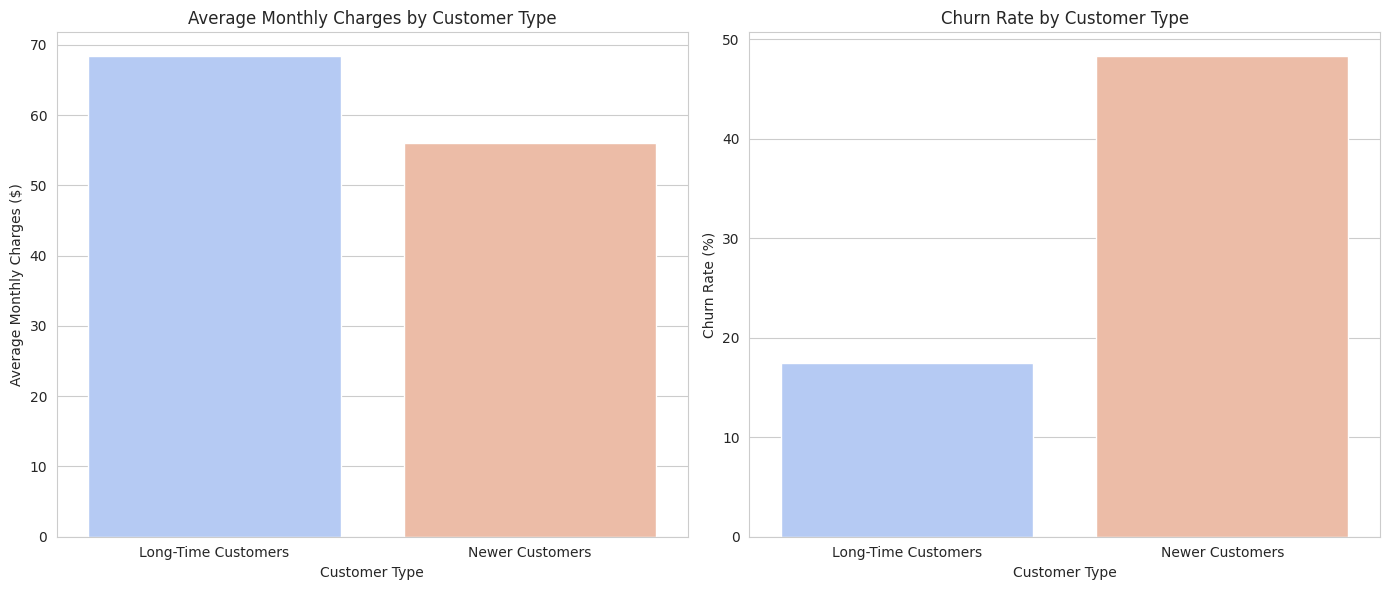

In [46]:
churn_tenure_df = churn_tenure_comparison_result.toPandas()

# Set up the figure for the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Average Monthly Charges
sns.barplot(data=churn_tenure_df, x='CustomerType', y='AverageMonthlyCharges', ax=axes[0], palette='coolwarm')
axes[0].set_title('Average Monthly Charges by Customer Type')
axes[0].set_xlabel('Customer Type')
axes[0].set_ylabel('Average Monthly Charges ($)')

# Plot for Churn Rate
sns.barplot(data=churn_tenure_df, x='CustomerType', y='ChurnRate', ax=axes[1], palette='coolwarm')
axes[1].set_title('Churn Rate by Customer Type')
axes[1].set_xlabel('Customer Type')
axes[1].set_ylabel('Churn Rate (%)')

# Show the plots
plt.tight_layout()
plt.show()

#### r) What is the correlation between senior citizen status and churn rate?

In [47]:
senior_churn_query = """
SELECT 
    SeniorCitizen, 
    COUNT(*) AS TotalCustomers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS ChurnedCustomers,
    (SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS ChurnRate
FROM 
    churn_data
GROUP BY 
    SeniorCitizen
ORDER BY 
    SeniorCitizen
"""

# Execute the query
senior_churn_result = spark.sql(senior_churn_query)

# Show the results
senior_churn_result.show()

+-------------+--------------+----------------+------------------+
|SeniorCitizen|TotalCustomers|ChurnedCustomers|         ChurnRate|
+-------------+--------------+----------------+------------------+
|            0|          5901|            1393|23.606168446026096|
|            1|          1142|             476| 41.68126094570928|
+-------------+--------------+----------------+------------------+



/tmp/ipykernel_41230/2315236408.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=senior_churn_df,


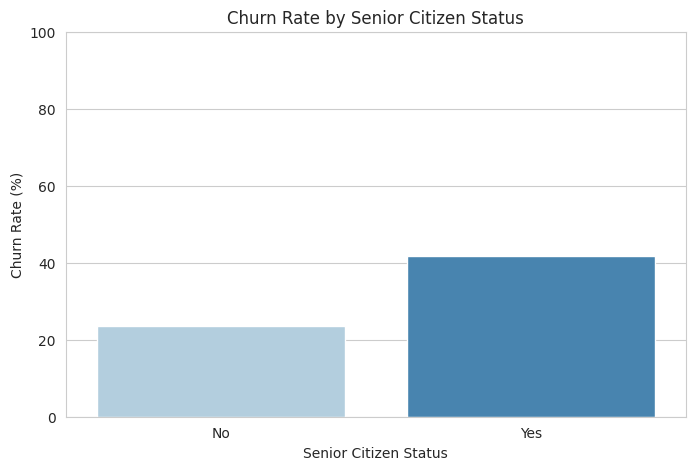

In [48]:
senior_churn_df = senior_churn_result.toPandas()

# Convert SeniorCitizen for better readability in the plot
senior_churn_df['SeniorCitizen'] = senior_churn_df['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

# Set up the plot
plt.figure(figsize=(8, 5))

# Create a bar plot
sns.barplot(data=senior_churn_df, 
            x='SeniorCitizen', 
            y='ChurnRate', 
            palette='Blues')

# Set the title and labels
plt.title('Churn Rate by Senior Citizen Status')
plt.xlabel('Senior Citizen Status')
plt.ylabel('Churn Rate (%)')
plt.ylim(0, 100)  # Set y-axis limits to show percentage

# Show the plot
plt.show()

#### s) Partition customers based on whether they are senior citizens and divide them into 5 groups based on tenure. (Use NTILE.)

In [49]:
partitioned_customers_query = """
SELECT 
    customerID,
    SeniorCitizen,
    tenure,
    NTILE(5) OVER (PARTITION BY SeniorCitizen ORDER BY tenure) AS TenureGroup
FROM 
    churn_data
ORDER BY 
    SeniorCitizen, TenureGroup, tenure
"""

# Execute the query
partitioned_customers_result = spark.sql(partitioned_customers_query)

# Show the results
partitioned_customers_result.show()

+----------+-------------+------+-----------+
|customerID|SeniorCitizen|tenure|TenureGroup|
+----------+-------------+------+-----------+
|4472-LVYGI|            0|     0|          1|
|3115-CZMZD|            0|     0|          1|
|5709-LVOEQ|            0|     0|          1|
|4367-NUYAO|            0|     0|          1|
|1371-DWPAZ|            0|     0|          1|
|7644-OMVMY|            0|     0|          1|
|3213-VVOLG|            0|     0|          1|
|2520-SGTTA|            0|     0|          1|
|2923-ARZLG|            0|     0|          1|
|4075-WKNIU|            0|     0|          1|
|2775-SEFEE|            0|     0|          1|
|7590-VHVEG|            0|     1|          1|
|1066-JKSGK|            0|     1|          1|
|8665-UTDHZ|            0|     1|          1|
|7310-EGVHZ|            0|     1|          1|
|2273-QCKXA|            0|     1|          1|
|5919-TMRGD|            0|     1|          1|
|6380-ARCEH|            0|     1|          1|
|3679-XASPY|            0|     1| 

#### t) Use PERCENT_RANK to identify the top 5% of customers by MonthlyCharges.

In [50]:

top_5_percent_customers_result = spark.sql("""
SELECT 
    CustomerID, MonthlyCharges,TotalCharges, InternetService, ROUND(PercentRank, 4)
FROM(
SELECT 
    customerID,
    MonthlyCharges,
    TotalCharges,
    InternetService,
    PERCENT_RANK() OVER (ORDER BY MonthlyCharges DESC) AS PercentRank
FROM 
    churn_data
ORDER BY 
    MonthlyCharges DESC
) AS _
WHERE PercentRank <= 0.05
""")

top_5_percent_customers_result.show()

24/09/24 07:21:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+--------------+------------+---------------+---------------------+
|CustomerID|MonthlyCharges|TotalCharges|InternetService|round(PercentRank, 4)|
+----------+--------------+------------+---------------+---------------------+
|7569-NMZYQ|        118.75|     8672.45|    Fiber optic|                  0.0|
|8984-HPEMB|        118.65|      8477.6|    Fiber optic|               1.0E-4|
|5989-AXPUC|         118.6|     7990.05|    Fiber optic|               3.0E-4|
|5734-EJKXG|         118.6|      7365.7|    Fiber optic|               3.0E-4|
|8199-ZLLSA|        118.35|     7804.15|    Fiber optic|               6.0E-4|
|9924-JPRMC|         118.2|     8547.15|    Fiber optic|               7.0E-4|
|2889-FPWRM|         117.8|      8684.8|    Fiber optic|               9.0E-4|
|3810-DVDQQ|         117.6|      8308.9|    Fiber optic|                0.001|
|9739-JLPQJ|         117.5|      8670.1|    Fiber optic|               0.0011|
|2302-ANTDP|        117.45|      5438.9|    Fiber op

###### u) Find customers who fall within the top 5% of the distribution based on monthly charges. Compare total charges with the next customer in the same internet service type, based on monthly charges.

In [51]:
top_5_percent_customers_result.createOrReplaceTempView('top_5_percent')

compare_charges_with_lag = spark.sql("""
SELECT
    *,
    PreviousTotalCharges - TotalCharges as Difference
FROM
(
    SELECT 
        customerID,
        MonthlyCharges,
        InternetService,
        TotalCharges,
        LAG(TotalCharges) OVER (PARTITION BY InternetService ORDER BY MonthlyCharges) AS PreviousTotalCharges
    FROM 
        top_5_percent
) AS _
""")

compare_charges_with_lag.show()

24/09/24 07:21:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+--------------+---------------+------------+--------------------+-------------------+
|customerID|MonthlyCharges|InternetService|TotalCharges|PreviousTotalCharges|         Difference|
+----------+--------------+---------------+------------+--------------------+-------------------+
|8024-XNAFQ|         107.4|    Fiber optic|     7748.75|                NULL|               NULL|
|6394-MFYNG|         107.4|    Fiber optic|      5121.3|             7748.75|            2627.45|
|9036-CSKBW|        107.45|    Fiber optic|      5680.9|              5121.3| -559.5999999999995|
|4056-QHXHZ|        107.45|    Fiber optic|      7576.7|              5680.9|-1895.8000000000002|
|5336-UFNZP|        107.45|    Fiber optic|      7047.5|              7576.7|  529.1999999999998|
|8265-HKSOW|        107.45|    Fiber optic|      7658.3|              7047.5| -610.8000000000002|
|5954-BDFSG|         107.5|    Fiber optic|      7853.7|              7658.3|-195.39999999999964|
|8800-ZKRFW|        

#### v) Find the top 5 customers with the highest MonthlyCharges within each Contract type.

In [52]:
top_customers_by_contract_result = spark.sql("""

SELECT *
FROM 
(SELECT 
        customerID,
        MonthlyCharges,
        Contract,
        ROW_NUMBER() OVER (PARTITION BY Contract ORDER BY MonthlyCharges DESC) AS Rank
    FROM 
        churn_data ) AS _
WHERE Rank <= 5
ORDER BY Contract, MonthlyCharges DESC
""")

top_customers_by_contract_result.show()


+----------+--------------+--------------+----+
|customerID|MonthlyCharges|      Contract|Rank|
+----------+--------------+--------------+----+
|2302-ANTDP|        117.45|Month-to-month|   1|
|8016-NCFVO|         116.5|Month-to-month|   2|
|9659-QEQSY|        115.65|Month-to-month|   3|
|4361-BKAXE|         114.5|Month-to-month|   4|
|6710-HSJRD|         114.1|Month-to-month|   5|
|5734-EJKXG|         118.6|      One year|   1|
|8199-ZLLSA|        118.35|      One year|   2|
|2889-FPWRM|         117.8|      One year|   3|
|4282-MSACW|         117.2|      One year|   4|
|3680-CTHUH|         116.6|      One year|   5|
|7569-NMZYQ|        118.75|      Two year|   1|
|8984-HPEMB|        118.65|      Two year|   2|
|5989-AXPUC|         118.6|      Two year|   3|
|9924-JPRMC|         118.2|      Two year|   4|
|3810-DVDQQ|         117.6|      Two year|   5|
+----------+--------------+--------------+----+



#### w) Calculate the churn rate in each Contract type and rank the contracts by churn rate.

In [53]:
churn_rate_by_contract_query = """
WITH ChurnRates AS (
    SELECT 
        Contract,
        COUNT(*) AS TotalCustomers,
        SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS ChurnedCustomers,
        (SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS ChurnRate
    FROM churn_data
    GROUP BY Contract
)
SELECT 
    Contract,
    ChurnRate,
    RANK() OVER (ORDER BY ChurnRate DESC) AS Rank
FROM ChurnRates
ORDER BY Rank
"""

churn_rate_by_contract_result = spark.sql(churn_rate_by_contract_query)

churn_rate_by_contract_result.show()

24/09/24 07:21:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 0

+--------------+------------------+----+
|      Contract|         ChurnRate|Rank|
+--------------+------------------+----+
|Month-to-month| 42.70967741935484|   1|
|      One year|11.269517990495586|   2|
|      Two year| 2.831858407079646|   3|
+--------------+------------------+----+



#### x) Perform an in-depth analysis of customers using window functions to understand customer rankings, distribution, and trends in charges and tenure.

In [54]:
# 1. Rank customers by total charges within each contract type
spark.sql("""
    SELECT customerID, Contract, TotalCharges,
           RANK() OVER (PARTITION BY Contract ORDER BY TotalCharges DESC) as rank_total_charges
    FROM churn_data
""").createOrReplaceTempView("ranked_customers")

# 2. Calculate percentile ranks for monthly charges
spark.sql("""
    SELECT customerID, MonthlyCharges,
           PERCENT_RANK() OVER (ORDER BY MonthlyCharges) as percentile_rank_monthly_charges
    FROM churn_data
""").createOrReplaceTempView("percentile_ranks")

# 3. Divide customers into 5 groups (quintiles) based on tenure
spark.sql("""
    SELECT customerID, tenure,
           NTILE(5) OVER (ORDER BY tenure) as tenure_quintile
    FROM churn_data
""").createOrReplaceTempView("tenure_quintiles")

# 4. Calculate the difference in monthly charges from the previous customer (ordered by customerID)
spark.sql("""
    SELECT customerID, MonthlyCharges,
           MonthlyCharges - LAG(MonthlyCharges) OVER (ORDER BY customerID) as charge_difference
    FROM churn_data
""").createOrReplaceTempView("charge_differences")

# 5. Calculate average monthly charges for each contract type and compare individual customers to this average
spark.sql("""
    SELECT customerID, Contract, MonthlyCharges,
           AVG(MonthlyCharges) OVER (PARTITION BY Contract) as avg_monthly_charges,
           MonthlyCharges - AVG(MonthlyCharges) OVER (PARTITION BY Contract) as difference_from_avg
    FROM churn_data
""").createOrReplaceTempView("contract_averages")

# 6. Identify customers with increasing monthly charges over their tenure
spark.sql("""
    SELECT customerID, tenure, MonthlyCharges,
           CASE WHEN MonthlyCharges > LAG(MonthlyCharges) OVER (PARTITION BY customerID ORDER BY tenure)
                THEN 1 ELSE 0 END as charge_increased
    FROM churn_data
""").createOrReplaceTempView("charge_increases")

# Now, let's run some queries to get insights
top_customers_query = spark.sql("""
    SELECT * FROM ranked_customers WHERE rank_total_charges <= 10
""")

high_value_customers_query = spark.sql("""
    SELECT * FROM percentile_ranks WHERE percentile_rank_monthly_charges >= 0.9
""")

long_tenure_customers_query = spark.sql("""
    SELECT * FROM tenure_quintiles WHERE tenure_quintile = 5
""")

customers_above_avg_charges_query = spark.sql("""
    SELECT * FROM contract_averages WHERE difference_from_avg > 0
""")

customers_with_increasing_charges_query = spark.sql("""
    SELECT customerID, SUM(charge_increased) as num_increases
    FROM charge_increases
    GROUP BY customerID
    HAVING SUM(charge_increased) > 0
    ORDER BY num_increases DESC
""")

24/09/24 07:21:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 07:21:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/24 0

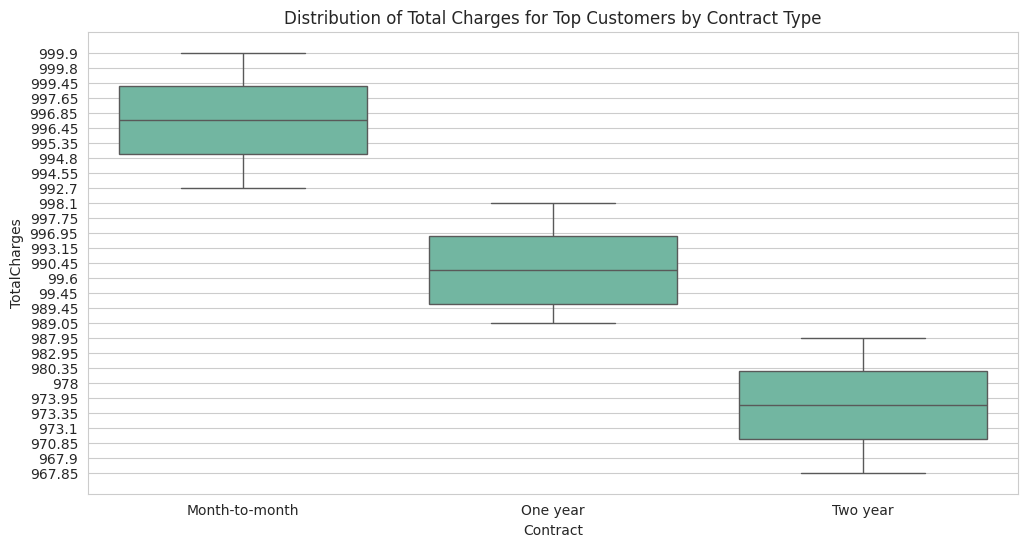

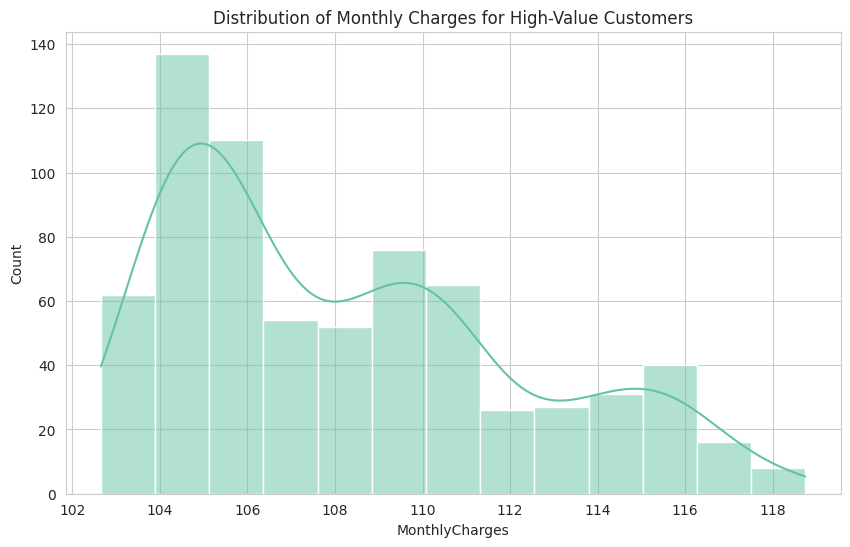

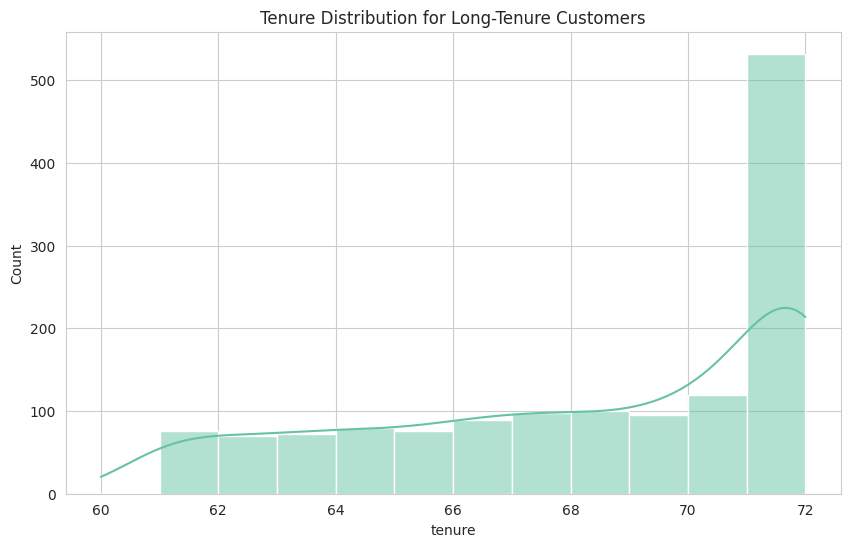

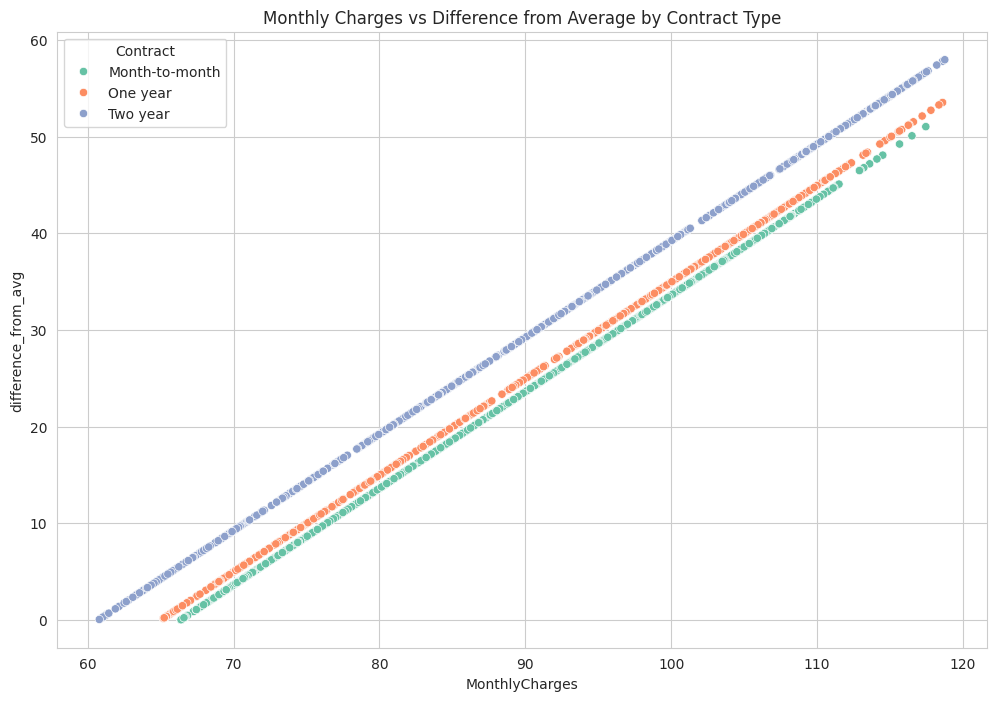

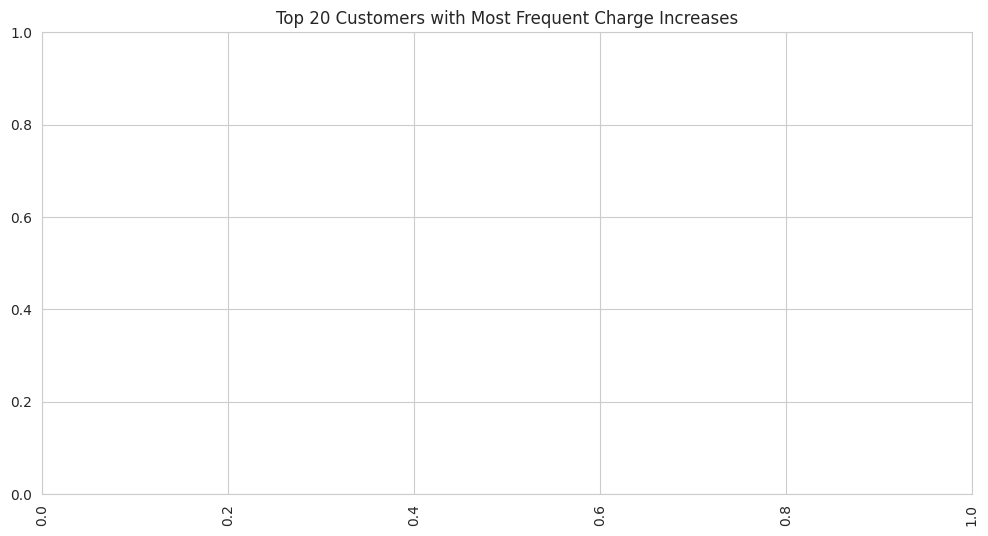

ValueError: could not convert string to float: ' '

<Figure size 1000x800 with 0 Axes>

In [55]:
top_customers_df = top_customers_query.toPandas()
high_value_customers_df = high_value_customers_query.toPandas()
long_tenure_customers_df = long_tenure_customers_query.toPandas()
customers_above_avg_charges_df = customers_above_avg_charges_query.toPandas()
customers_with_increasing_charges_df = customers_with_increasing_charges_query.toPandas()
churn_df2 = churn_df.dropna()

# Set the style for all plots
sns.set_style("whitegrid")

# 1. Distribution of total charges for top customers by contract type
plt.figure(figsize=(12, 6))
sns.boxplot(x="Contract", y="TotalCharges", data=top_customers_df)
plt.title("Distribution of Total Charges for Top Customers by Contract Type")
plt.show()

# 2. Distribution of monthly charges for high-value customers
plt.figure(figsize=(10, 6))
sns.histplot(data=high_value_customers_df, x="MonthlyCharges", kde=True)
plt.title("Distribution of Monthly Charges for High-Value Customers")
plt.show()

# 3. Tenure distribution for long-tenure customers
plt.figure(figsize=(10, 6))
sns.histplot(data=long_tenure_customers_df, x="tenure", kde=True)
plt.title("Tenure Distribution for Long-Tenure Customers")
plt.show()

# 4. Scatter plot of monthly charges vs difference from average, colored by contract type
plt.figure(figsize=(12, 8))
sns.scatterplot(data=customers_above_avg_charges_df, x="MonthlyCharges", y="difference_from_avg", hue="Contract")
plt.title("Monthly Charges vs Difference from Average by Contract Type")
plt.show()

# 5. Top 20 customers with the most frequent charge increases
plt.figure(figsize=(12, 6))
sns.barplot(data=customers_with_increasing_charges_df.head(20), x="customerID", y="num_increases")
plt.title("Top 20 Customers with Most Frequent Charge Increases")
plt.xticks(rotation=90)
plt.show()

# 6. Correlation heatmap for numeric variables
numeric_df = churn_df2.select("tenure", "MonthlyCharges", "TotalCharges").toPandas()
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap for Numeric Variables")
plt.show()